In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### TRAINING A UNET MODEL ON SEGMENTATION TASK

In this notebook we are going to perform data loading, model definition, training, inference and evaluation. Making sure that the codes are simple and beginners supporting stay focused and fill free to ***copy and edit*** the notebook.

In [55]:
#imports 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

In [56]:
# Here we perform dataloading for Images

folder_path = '/kaggle/input/tree-binary-segmentation/images/images'
def csv(folder_path):
    image_files = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
    ])

    image_data = []

    for file_name in image_files:
        full_path = os.path.join(folder_path, file_name)
    
        try:
            with Image.open(full_path) as img:
                img.verify()  

                image_data.append({'file':file_name,'full_path_mask': full_path})
        except Exception as e:
            print(f"corrupted: {file_name} -> {e}")

    df = pd.DataFrame(image_data)
    csv_path = 'image_paths.csv'

    return df

def csv_(folder_path):
    image_files = sorted([
    f for f in os.listdir(folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
    ])

    image_data = []

    for file_name in image_files:
        full_path = os.path.join(folder_path, file_name)
    
        try:
            with Image.open(full_path) as img:
                img.verify()  

                image_data.append({'file':file_name,'full_path': full_path})
        except Exception as e:
            print(f"corrupted: {file_name} -> {e}")

    df = pd.DataFrame(image_data)
    csv_path = 'image_paths.csv'

    return df



In [57]:
# Lets visualize what the mask looks like

train_path = csv_(folder_path = '/kaggle/input/tree-binary-segmentation/images/images')

train_masks = csv(folder_path = '/kaggle/input/tree-binary-segmentation/masks/masks')

train_masks

,file,full_path_mask
0,0.png,/kaggle/input/tree-binary-segmentation/masks/m...
1,1.png,/kaggle/input/tree-binary-segmentation/masks/m...
2,10.png,/kaggle/input/tree-binary-segmentation/masks/m...
3,100.png,/kaggle/input/tree-binary-segmentation/masks/m...
4,1000.png,/kaggle/input/tree-binary-segmentation/masks/m...
...,...,...
2713,995.png,/kaggle/input/tree-binary-segmentation/masks/m...
2714,996.png,/kaggle/input/tree-binary-segmentation/masks/m...
2715,997.png,/kaggle/input/tree-binary-segmentation/masks/m...
2716,998.png,/kaggle/input/tree-binary-segmentation/masks/m...


In [58]:
# What does the data that we have means 

data = pd.concat([train_path,train_masks], axis= 1)

data.drop('file', axis=1, inplace = True)

data.shape

data.head()

,full_path,full_path_mask
0,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
1,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
2,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
3,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...
4,/kaggle/input/tree-binary-segmentation/images/...,/kaggle/input/tree-binary-segmentation/masks/m...


#### CREATING A DATA LOADING BY SPLIT ALGORITHM

<PIL.Image.Image image mode=RGB size=512x512 at 0x78A7A93D6E10>


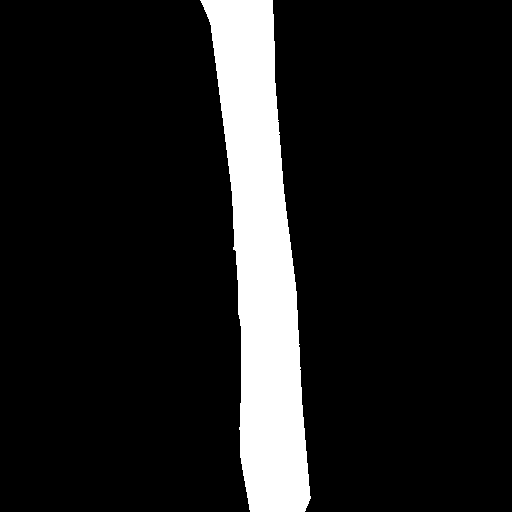

In [59]:
# Here we load data in the training and validation dataset and visualizing a sample

X = data.drop('full_path_mask', axis=1)
y = data.drop('full_path', axis = 1)
y.head()

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state = 42, shuffle = True)

X_train['image'] =X_train['full_path'].apply(lambda x: open(x, 'rb').read())
X_train.drop(['full_path'], axis= 1, inplace = True)

y_train.head()

y_train['image'] =y_train['full_path_mask'].apply(lambda x: open(x, 'rb').read())
y_train.drop(['full_path_mask'], axis= 1, inplace = True)
X_val['image'] =X_val['full_path'].apply(lambda x: open(x, 'rb').read())
X_val.drop(['full_path'], axis= 1, inplace = True)
y_val['image'] =y_val['full_path_mask'].apply(lambda x: open(x, 'rb').read())
y_val.drop(['full_path_mask'], axis= 1, inplace = True)


X_train['image'] = X_train['image'].apply(lambda x: Image.open(BytesIO(x)).convert('RGB'))
y_train['image'] = y_train['image'].apply(lambda x: Image.open(BytesIO(x)).convert('L'))
X_val['image'] = X_val['image'].apply(lambda x: Image.open(BytesIO(x)).convert('RGB'))
y_val['image'] = y_val['image'].apply(lambda x: Image.open(BytesIO(x)).convert('L'))

print(X_train.iloc[0]['image'])


y_train.iloc[0]['image']

In [60]:
# creating a transform for images

transformer =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]) 

In [61]:
# making a transform for labeels making sure that it is smilar to that of images to insure alignment

label_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [62]:
# now we define a class for loading a torch dataset

class dataset(Dataset):
    def __init__(self,dataframe, transformer = None , label_trans = None):
        super().__init__()
        self.dataframe = dataframe
        self.transformer = transformer
        self.label_trans = label_trans
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']

        if self.transformer:
            image = self.transformer(image)
        if self.label_trans:    
            label = self.label_trans(label)
        return image, label



In [63]:
X_val.head()

,image
2072,<PIL.Image.Image image mode=RGB size=512x512 a...
443,<PIL.Image.Image image mode=RGB size=512x512 a...
1397,<PIL.Image.Image image mode=RGB size=512x512 a...
2567,<PIL.Image.Image image mode=RGB size=512x512 a...
1017,<PIL.Image.Image image mode=RGB size=512x512 a...


In [64]:
# now we modeify the train and the validation target format to fit the dataset
# definition and workflow

y_train['label'] = y_train['image']
y_train.drop('image', axis=1, inplace =True)

y_val['label'] = y_val['image']
y_val.drop('image', axis = 1, inplace = True)


train_data = pd.concat([X_train,y_train], axis = 1)
val_data = pd.concat([X_val,y_val], axis = 1)

val_data.head()

,image,label
2072,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
443,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
1397,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
2567,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...
1017,<PIL.Image.Image image mode=RGB size=512x512 a...,<PIL.Image.Image image mode=L size=512x512 at ...


In [65]:
# creating the validation and training dataset and visualizing the format of one sample

train_dataset = dataset(train_data, transformer = transformer, label_trans=label_transform)
val_dataset = dataset(val_data, transformer = transformer, label_trans=label_transform)

image,_ = val_dataset[0]

train_loader = DataLoader(train_dataset, batch_size = 3)
val_loader = DataLoader(val_dataset, batch_size = 3)

image

tensor([[[0.1176, 0.1569, 0.1647,  ..., 0.2353, 0.2196, 0.2157],
         [0.1333, 0.1686, 0.1490,  ..., 0.2275, 0.2157, 0.2000],
         [0.1608, 0.1804, 0.1412,  ..., 0.2078, 0.2000, 0.2235],
         ...,
         [0.2667, 0.1373, 0.0784,  ..., 0.0980, 0.1608, 0.2667],
         [0.1843, 0.1020, 0.1255,  ..., 0.1059, 0.1490, 0.2078],
         [0.1137, 0.1216, 0.2902,  ..., 0.1216, 0.0941, 0.0941]],

        [[0.1137, 0.1373, 0.1373,  ..., 0.2510, 0.2471, 0.2588],
         [0.1255, 0.1529, 0.1255,  ..., 0.2353, 0.2392, 0.2314],
         [0.1412, 0.1608, 0.1255,  ..., 0.2078, 0.2118, 0.2431],
         ...,
         [0.2588, 0.1490, 0.0941,  ..., 0.0745, 0.1373, 0.2431],
         [0.1843, 0.1137, 0.1333,  ..., 0.0902, 0.1294, 0.1882],
         [0.1098, 0.1216, 0.2824,  ..., 0.1059, 0.0745, 0.0745]],

        [[0.0706, 0.0941, 0.0941,  ..., 0.2000, 0.1961, 0.2078],
         [0.0902, 0.1137, 0.0863,  ..., 0.1961, 0.2039, 0.2039],
         [0.1098, 0.1255, 0.0824,  ..., 0.1765, 0.1922, 0.

In [66]:
# Unet model definition.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv, with crucial padding fix for non-power-of-2 sizes."""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match the size of x2 (the skip connection)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): 
        return self.conv(x)

class Model(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(Model, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [67]:
# Loading the model and optimizer for fine-tuning

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

bohrium_model = Model()

optimizer = torch.optim.Adam(bohrium_model.parameters(), lr= 1e-3, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
bohrium_model.to(device)

cuda


Model(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [68]:
## Create a fresh instance of the model (must match architecture)
bohrium_model = Model()  
bohrium_model.load_state_dict(torch.load("/kaggle/input/unet-fine-tuned-for-tree-segmentation/pytorch/default/1/best_model.pth", map_location=device))
bohrium_model.to(device)
bohrium_model.eval()

print("✅ Best model loaded and ready for inference!")



✅ Best model loaded and ready for inference!


In [69]:
# uncomment this for fine tuning but note that the best model weights are directly loaded 
# without fine-tuning need
'''
import torch
import torch.nn as nn
from tqdm import tqdm

# Training parameters
epochs = 50
patience = 5   # stop if no improvement after N epochs
best_loss = float(0.8)
counter = 0  # early stopping counter

criterion = nn.CrossEntropyLoss()

bohrium_model.train()
for epoch in range(epochs):
    # ---- Training ----
    bohrium_model.train()
    train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    for image, label in pbar:
        image, label = image.to(device), label.to(device)
        
        if label.dim() == 4 and label.size(1) == 1:
            label = label.squeeze(1)
        label = label.long()

        optimizer.zero_grad()
        output = bohrium_model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * image.size(0)
    
    avg_train_loss = train_loss / len(train_loader.dataset)

    # ---- Validation ----
    bohrium_model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    
    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=True)
    with torch.no_grad():
        for image, label in pbar:
            image = image.to(device)
            if label.dim() == 4 and label.size(1) == 1:
                label = label.squeeze(1)   # [B, H, W]
            label = label.long().to(device)

            output = bohrium_model(image)
            loss = criterion(output, label)
            val_loss += loss.item() * image.size(0)

            prediction = torch.argmax(output, dim=1)
            correct += (prediction == label).sum().item()
            total += label.numel()

            pbar.set_postfix({
                "val_loss": loss.item(),
                "val_acc": f"{correct / total:.4f}"
            })
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"\nEpoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")

    # ---- Model Saving & Early Stopping ----
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(bohrium_model.state_dict(), "best_model.pth")
        print("Model saved (improved validation loss)")
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break
'''

'\nimport torch\nimport torch.nn as nn\nfrom tqdm import tqdm\n\n# Training parameters\nepochs = 50\npatience = 5   # stop if no improvement after N epochs\nbest_loss = float(0.8)\ncounter = 0  # early stopping counter\n\ncriterion = nn.CrossEntropyLoss()\n\nbohrium_model.train()\nfor epoch in range(epochs):\n    # ---- Training ----\n    bohrium_model.train()\n    train_loss = 0.0\n    \n    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")\n    for image, label in pbar:\n        image, label = image.to(device), label.to(device)\n        \n        if label.dim() == 4 and label.size(1) == 1:\n            label = label.squeeze(1)\n        label = label.long()\n\n        optimizer.zero_grad()\n        output = bohrium_model(image)\n        loss = criterion(output, label)\n        loss.backward()\n        optimizer.step()\n\n        train_loss += loss.item() * image.size(0)\n    \n    avg_train_loss = train_loss / len(train_loader.dataset)\n\n    # ---- Validation ---

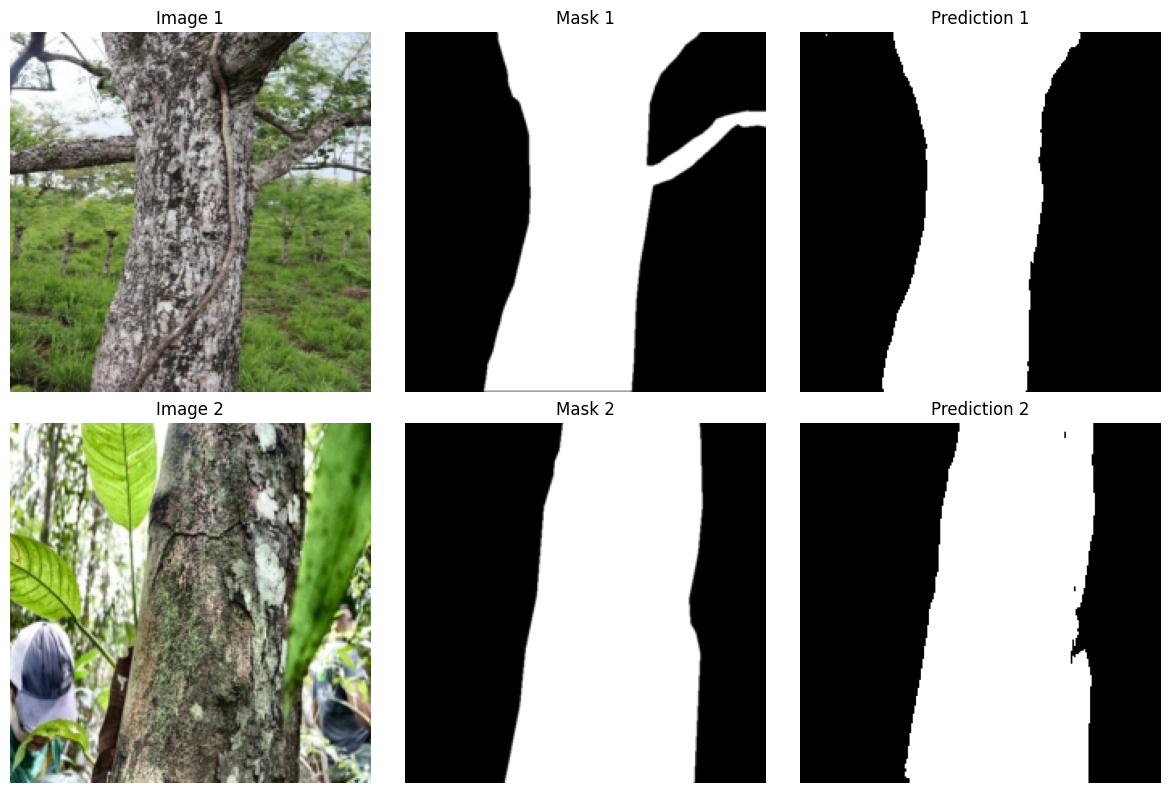

In [84]:
img, lab = val_dataset[2]
image, label = val_dataset[8]

output = bohrium_model(img.unsqueeze(0).to(device))
pred = torch.argmax(output, dim = 1).cpu()
output = bohrium_model(image.unsqueeze(0).to(device))
prediction = torch.argmax(output, dim = 1).cpu()


# Create a 2-row, 3-column plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# First row (img, lab, pred)
axes[0, 0].imshow(img.view(-1, 224, 224).permute(1, 2, 0).cpu().numpy())
axes[0, 0].set_title("Image 1")
axes[0, 0].axis("off")

axes[0, 1].imshow(lab.squeeze().cpu().numpy(), cmap='gray')
axes[0, 1].set_title("Mask 1")
axes[0, 1].axis("off")

axes[0, 2].imshow(pred.squeeze().cpu().numpy(), cmap='gray')
axes[0, 2].set_title("Prediction 1")
axes[0, 2].axis("off")

# Second row (image, label, prediction)
axes[1, 0].imshow(image.view(-1, 224, 224).permute(1, 2, 0).cpu().numpy())
axes[1, 0].set_title("Image 2")
axes[1, 0].axis("off")

axes[1, 1].imshow(label.squeeze().cpu().numpy(), cmap='gray')
axes[1, 1].set_title("Mask 2")
axes[1, 1].axis("off")

axes[1, 2].imshow(prediction.squeeze().cpu().numpy(), cmap='gray')
axes[1, 2].set_title("Prediction 2")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()
